> 強化学習苦手の会 Advent Calendar 2020 20日目
# 1. はじめに

> Note: このブログは[強化学習苦手の会 Advent Calendar 2020](https://adventar.org/calendars/5128)20日目の記事として書かれました



強化学習は、逐次的に意思決定する問題を定義するためのフレームワークです。
従来は大変だった[^1] ニューラルネットワークの訓練が簡単になったことや、
Alpha GOなど深層強化学習(Deep RL)の成功を背景に、[対話システム][Li16]・[経済][Zheng20]
など、様々なアプリケーションで強化学習の利用が試みられているように思います。
僕個人としても、強化学習は汎用的で面白いツールだと思うので、将来的には色々な応用分野で広く活用されるといいな、と思います。

一方で、強化学習を何か特定の問題に応用してみよう、という場面では、
その汎用性ゆえかえってとっつきにくい・扱いづらい面があるように思います。
実際に、苦手の会などで応用研究をされている方から、
- 問題を定義するのがそもそも大変
- 色々な手法があって、何がなんだかよくわからない

などの意見を観測できました。

では応用研究に対する「ツール」として強化学習を扱う上で何が大事なのだろう、と考えたとき、
僕は**簡単な問題を設計することこそが大事だ**という仮説に思いいたりました。
簡単な問題を設計するためには、強化学習の中でもどういう問題が難しいのか、
ということをきちんと理解しておく必要があるように思います。

そこでこのブログ記事では、強化学習の中でも「難しい問題」がどういうものなのか、
そういう問題はなぜ難しいのかについて、例を通してなるべく直感的に説明することを試みます。
強化学習の難しさがわかった暁には、きっと
- そもそも強化学習を使わないという選択ができるし、
- なるべく簡単に解けるような強化学習の問題を設計できるし、
- 問題に合わせて手法を選択できる

ことでしょう。

記事の構成として、強化学習の難しさについて「場合分け」を行い、
- MDPを解くことの難しさ
- データを収集することの難しさ

という2つの観点から整理していきます。

前提知識について、初心者の方でも読めるように、
強化学習についての知識についてはなるべく記事の中で補足します。
しかし、すごく雑に書くので、詳細は[Reinforcement Learning: An Introduction][RLBook]
などの教科書を参照されるといいと思います。
また、プログラムを見たほうがイメージしやすい（方もいる）かと思ってPythonのコード例をたまに出しています。
コード例では、$\sum_{s} f(s) g(s, a)$のようにテンソルの適当な軸で掛け算して足し込む演算に
[numpy.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)
を多用しているので、知っていたほうが読みやすいかもしれません。

[Li16]: https://arxiv.org/abs/1606.01541
[Zheng20]: https://arxiv.org/abs/2004.13332
[RLBook]: http://incompleteideas.net/book/the-book.html

[^1]: Suttonも[誤差逆伝播を使うのにはトリッキーな工夫が必要だ](http://incompleteideas.net/RL-FAQ.html#backpropagation)と言っています。

# 2. 最適化問題としての側面: MDPを解くことの難しさ

強化学習は、エージェントが集めてきたデータを使って、マルコフ決定過程上で「いい感じ」に行動する方策を
訓練する問題のことです。
しかしこの章では、いったん「学習」のことは忘れましょう。
学習しないでいいのは、環境の情報を全部知っているからです。
このとき、どのくらい問題を解くのが大変なのでしょうか？

ではまず、マルコフ決定過程 (Markov Decision Process, 以後MDPと呼ぶ)を導入します。


------
**定義1: MDP** 

MDPは、
状態集合 $\mathcal{S}$、
行動集合 $\mathcal{A}$、
状態遷移確率 $P: \mathcal{S} \times \mathcal{A} \rightarrow \mathcal{S}$, 
報酬関数 $r: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$[^2], 
割引報酬率 $0 \leq \gamma < 1$ から成る

-------

なんだか、記号で言われてもよくわからないですね。
せっかくなので、お絵描きしてみましょう。

[^2]: この報酬関数は最も簡単な定義です。他に$r: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \rightarrow \mathbb{R}$(遷移先に依存)、$r: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{E}[R_{s, a}]$（確率的）があります。

In [1]:
from typing import Dict, List, Optional, Sequence, Tuple, TypeVar

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.text import Annotation

# Some types for annotations
T = TypeVar("T")


class Array(Sequence[T]):
    pass


Array1 = Array[float]
Array2 = Array[Array1]
Array3 = Array[Array2]
Point = Tuple[float, float]


def a_to_b(
    ax: Axes,
    a: Point,
    b: Point,
    text: str = "",
    style: str = "normal",
    **kwargs,
) -> Annotation:
    """Draw arrow from a to b. Optionally"""

    STYLE_ALIASES: Dict[str, str] = {
        "normal": "arc3,rad=-0.4",
        "self": "arc3,rad=-1.6",
    }
    arrowkwargs = {}
    for arrowkey in list(filter(lambda key: key.startswith("arrow"), kwargs)):
        arrowkwargs[arrowkey[5:]] = kwargs.pop(arrowkey)
    if len(text) > 0:
        bbox = dict(
            boxstyle="round",
            fc="w",
            ec=arrowkwargs.get("color", "k"),
            alpha=arrowkwargs.get("alpha", 1.0),
        )
    else:
        bbox = None
    return ax.annotate(
        text,
        xy=b,
        xytext=a,
        arrowprops=dict(
            shrinkA=10,
            shrinkB=10,
            width=1.0,
            headwidth=6.0,
            connectionstyle=STYLE_ALIASES.get(style, style),
            **arrowkwargs,
        ),
        bbox=bbox,
        **kwargs,
    )


class ChainMDP:
    """Chain MDP with N states and two actions."""

    ACT_COLORS: List[str] = ["xkcd:vermillion", "xkcd:light royal blue"]
    INTERVAL: float = 1.2
    OFFSET: float = 0.8
    SHIFT: float = 0.5
    HEIGHT: float = 4.0

    def __init__(
        self,
        success_probs: Sequence[Sequence[float]],
        reward_function: Sequence[Sequence[float]],
    ) -> None:
        success_probs = np.array(success_probs)
        self.n_states = success_probs.shape[0]
        assert success_probs.shape[1] == 2
        np.testing.assert_almost_equal(success_probs >= 0, np.ones_like(success_probs))
        np.testing.assert_almost_equal(success_probs <= 1, np.ones_like(success_probs))
        self.p = np.zeros((self.n_states, 2, self.n_states))
        for si in range(self.n_states):
            left, right = max(0, si - 1), min(self.n_states - 1, si + 1)
            # Action 0 is for right
            self.p[si][0][right] += success_probs[si][0]
            self.p[si][0][si] += 1.0 - success_probs[si][0]
            # Action 1 is for left
            self.p[si][1][left] += success_probs[si][1]
            self.p[si][1][si] += 1.0 - success_probs[si][1]

        self.r = np.array(reward_function)  # |S| x 2
        assert self.r.shape == (self.n_states, 2)
        # For plotting
        self.circles = []
        self.cached_ax = None
        
    def figure_shape(self) -> Tuple[int, int]:
        width = self.n_states + (self.n_states - 1) * self.INTERVAL + self.OFFSET * 2.5
        height = self.HEIGHT
        return width, height

    def show(self, title: str = "", ax: Optional[Axes] = None) -> Axes:
        if self.cached_ax is not None:
            return self.cached_ax
        
        from matplotlib.patches import Circle

        width, height = self.figure_shape()
        circle_position = height / 2 - height / 10
        if ax is None:
            fig = plt.figure(title or "ChainMDP", (width, height))
            ax = fig.add_axes([0, 0, 1, 1], aspect=1.0)
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_xticks([])
        ax.set_yticks([])

        def xi(si: int) -> float:
            return self.OFFSET + (1.0 + self.INTERVAL) * si + 0.5

        self.circles = [
            Circle((xi(i), circle_position), 0.5, fc="w", ec="k")
            for i in range(self.n_states)
        ]
        for i in range(self.n_states):
            x = self.OFFSET + (1.0 + self.INTERVAL) * i + 0.1
            ax.text(x, height * 0.85, f"State {i}", fontsize=16)

        def annon(act: int, prob: float, *args, **kwargs) -> None:
            # We don't hold references to annotations (i.e., we treat them immutable)
            a_to_b(
                ax,
                *args,
                **kwargs,
                arrowcolor=self.ACT_COLORS[act],
                text=f"P: {prob:.02}",
                arrowalpha=prob,
                fontsize=11,
            )

        for si in range(self.n_states):
            ax.add_patch(self.circles[si])
            x = xi(si)
            # Action 0:
            y = circle_position + self.SHIFT
            if si < self.n_states - 1 and 1e-3 < self.p[si][0][si + 1]:
                p_right = self.p[si][0][si + 1]
                annon(
                    0,
                    p_right,
                    (x + self.SHIFT, y),
                    (xi(si + 1) - self.SHIFT * 1.2, y - self.SHIFT * 0.3),
                    verticalalignment="center_baseline",
                )
            else:
                p_right = 0.0
            if p_right + 1e-3 < 1.0:
                annon(
                    0,
                    1.0 - p_right,
                    (x - self.SHIFT * 1.2, y),
                    (x + self.SHIFT * 0.5, y - self.SHIFT * 0.1),
                    style="self",
                    verticalalignment="bottom",
                )
            ax.text(
                x - self.SHIFT * 1.2,
                y + self.SHIFT * 1.4,
                f"r({si}, 0): {self.r[si][0]:+.02}",
                color=self.ACT_COLORS[0],
                fontsize=14,
            )
            # Action 1:
            y = circle_position - self.SHIFT
            if 0 < si and 1e-3 < self.p[si][1][si - 1]:
                p_left = self.p[si][1][si - 1]
                annon(
                    1,
                    self.p[si][1][si - 1],
                    (x - self.SHIFT * 1.6, y),
                    (xi(si - 1) + self.SHIFT * 1.4, y + self.SHIFT * 0.2),
                    verticalalignment="top",
                )
            else:
                p_left = 0.0
            if p_left + 1e-3 < 1.0:
                annon(
                    1,
                    1.0 - p_left,
                    (x + self.SHIFT * 0.4, y),
                    (x - self.SHIFT * 0.45, y + self.SHIFT * 0.1),
                    style="self",
                    verticalalignment="top",
                )
            ax.text(
                x - self.SHIFT * 1.2,
                y - self.SHIFT * 1.4,
                f"r({si}, 1): {self.r[si][1]:+.02}",
                color=self.ACT_COLORS[1],
                fontsize=14,
            )

        for i in range(2):
            ax.plot([0.0], [0.0], color=self.ACT_COLORS[i], label=f"Action {i}")
        ax.legend(fontsize=11, loc="upper right")
        if len(title) > 0:
            ax.text(0.06, height * 0.9, title, fontsize=18)
        self.cached_ax = ax
        return ax

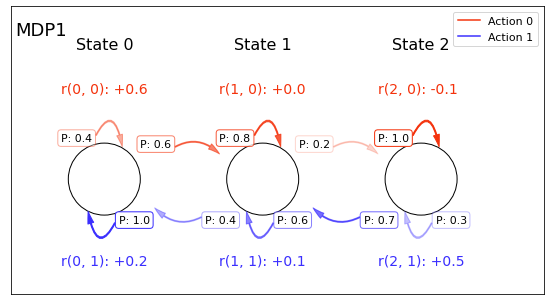

In [2]:
mdp1 = ChainMDP(
    [[0.6, 0.7], [0.2, 0.4], [0.3, 0.7]], [[0.6, 0.2], [0.0, 0.1], [-0.1, 0.5]]
)
ax = mdp1.show(title="MDP1")

MDPはこのように、状態を頂点とするグラフとして表現できます。
このMDPには3つの状態(図中のState 0, 1, 2)があり、各状態で、2つの行動のどちらかを選択できます。
よって $\mathcal{S} = \{s_0, s_1, s_2\}, \mathcal{A} = \{a_0, a_1\}$です。
各行動は、以下のように特徴づけられます。
- 赤の行動(Action 0) をとると、一つ右の頂点へ遷移するか、失敗して今の頂点にとどまる
- 青の行動(Action 1) をとると、一つ左の頂点へ遷移するか、失敗して今の頂点にとどまる

このような確率的なグラフの上で、ある行動方針 $\pi: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$
に従って行動するエージェントを考えます。
行動方針が決まれば、貰える割引報酬和の期待値が、以下のように定まります。
これを状態価値と呼びます。

------
**定義2: 状態価値関数 $V^\pi$**を以下のように定義する。

$V^\pi(s) := \sum_{a \in \mathcal{A}} \pi(a|s) \left( r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s'|s, a) V^\pi(s') \right)$

------

この時、強化学習は $\sum_{s \in \mathcal{S}} V^\pi(s)$ を最大化するような $\pi$を求める問題になります。[^3] 
そのような $\pi$ を **最適方策** $\pi^*$ と呼びます。また、$V^{\pi^*}$ を略記して $V^*$ と書きます。

手始めに、簡単な問題で $V^*$ を求めてみましょう。

[^3]: 初期状態分布(雑に言うと、スタート地点の分布)を$\mu(s)$とすると、$ \sum_{s\in\mathcal{S}} \mu(s)V_\pi(s)$ がエージェントが獲得する割引報酬和の期待値です。$V_\pi(s)$ が最大ならこれも最大になります。

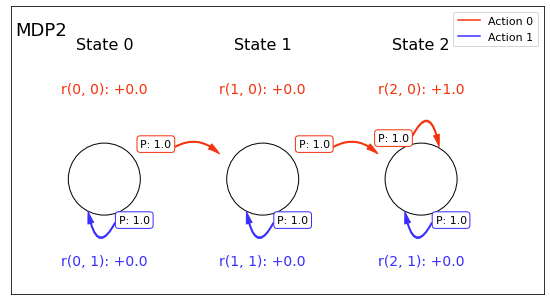

In [3]:
mdp2 = ChainMDP(
    [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [1.0, 0.0]]
)
_ = mdp2.show("MDP2")

この問題の最適方策 $\pi^*$ は、明らかですね。
一番右の状態でしか報酬が出ないので、全ての状態において右に行けばいいです。

また、この時の $V^*$ も求めてみます。

まず、状態2は **吸引状態** であり、状態2に辿りついてしまったらもう他の状態には遷移できません。
よって、

$$
\begin{aligned}
V^*(2) &= 1.0 + \gamma V^*(2) \\　
       &= 1.0 + \gamma (1.0 + \gamma V^*(2)) \\
       &= 1.0 + \gamma + \gamma^2 + \gamma^3 + ... \\
       &= \lim_{n \to \infty} \frac{1 - \gamma ^ n}{1 - \gamma} \\
       &= \frac{1}{1 - \gamma} ~~~~~(\gamma < 1より)
\end{aligned}
$$

となります。
たとえば $\gamma = 0.9$ なら、

$$
\begin{aligned}
V^*(2) &= \frac{1}{1 - \gamma} = 10 \\
V^*(1) &= 0.0 + \gamma * V^*(2) = 9 \\
V^*(0) &= 0.0 + \gamma * V^*(1) = 8.1 
\end{aligned}
$$

ですね。

この例から、$\pi$にもとづいて行動した時、吸引状態以外のループにはまりえないなら、
$O(|\mathcal{S}|^2|\mathcal{A}|)$ (状態数の2乗と行動数に比例するオーダー)で $V^\pi$ が評価できることがわかります。
この場合は$\pi$も$P$も決定的なので実質$O(|S|)$になっています。

## 2.1: $V^\pi\cdot V^*$を評価する難しさ
では、もう少し難しいMDPを考えてみましょう。

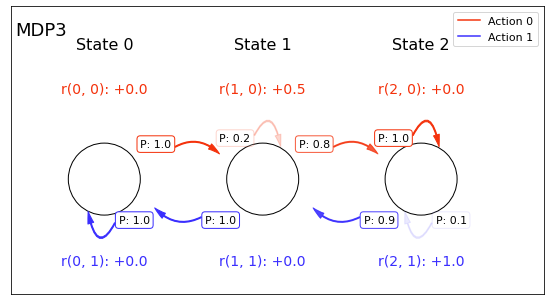

In [4]:
mdp3 = ChainMDP(
    [[1.0, 0.0], [0.8, 1.0], [1.0, 0.9]], [[0.0, 0.0], [0.5, 0.0], [0.0, 1.0]]
)
_ = mdp3.show("MDP3")

今度は、State 1で右に、State 2で左に行けば良さそうです。
$$
\begin{aligned}
V^* (1) = 0.5 + \gamma (0.1 * V^*(1) + 0.9 * V^*(2)) \\
V^* (2) = 1.0 + \gamma (0.8 * V^*(1) + 0.2 * V^*(2))
\end{aligned}
$$

先ほどの問題と違って1も2も吸引状態ではないので、$V(1)$と$V(2)$がお互いに依存する面倒な
方程式が出てきてしまいました。
このような**ループの存在**が、強化学習を難しくしている要素の一つです。

とはいえ、コンピューターで数値的に解くのは簡単です。
状態$s$にいて、あと$n$回行動できる時の価値関数を$V_n^\pi(s)$と書きます。
任意の$s$について、$V_0^\pi(s) = 0$です（1回も行動できないので!）。
$V_i^\pi$ から $V_{i + 1}^\pi$ を求めるには、1ステップだけ先読みすればいいので、
$$
V_{i + 1}^\pi(s) = \sum_{a \in \mathcal{A}} \pi(a|s) \left( r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s'|s, a) V_{i}^\pi(s') \right)
$$
で計算できます。$\gamma < 1$によりこの反復計算は収束し、$V^\pi$ が求まります。
実際にプログラムで書いてみましょう。

In [5]:
MAX_ITER_V_PI: int = int(1e5)


def v_pi(
    r: Array2,
    p: Array3,
    pi: Array2,
    gamma: float,
    epsilon: float,
) -> Tuple[Array1, int]:
    v = np.zeros(r.shape[0])  # Vπ
    r_pi = np.einsum("sa,sa->s", pi, r)  # |S|, πを使ったときに貰う報酬のベクトル
    p_pi = np.einsum("saS,sa->sS", p, pi)  # |S| x |S|, πを使ったときの状態遷移確率
    for n_iter in range(MAX_ITER_V_PI):
        v_next = r_pi + gamma * np.einsum("s,sS", v, p_pi.T)
        if np.all(np.absolute(v_next - v) < epsilon):
            return v_next, n_iter + 1
        v = v_next
    # 理論的には必ず収束するので、バグ予防
    raise RuntimeError("Policy Evaluation did not converge >_<")


pi_star = np.array([[1.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
v_star_mdp3, n_iter = v_pi(mdp3.r, mdp3.p, pi_star, gamma=0.9, epsilon=1e-4)
print(f"反復回数: {n_iter}")
print(" ".join([f"V({i}): {v:.3}" for i, v in enumerate(v_star_mdp3)]))

反復回数: 86
V(0): 6.49 V(1): 7.21 V(2): 7.51


86回この計算を反復した後、なんかそれっぽい数字が出てきました。
この反復回数は、何によって決まるのでしょうか？

任意の $s$ について $|V_{i+1}^\pi(s) - V_i^\pi(s)| < \epsilon$ なら計算終わり、とします[^4]。
$V_n^\pi(s)$は「あと$n$ステップ行動できる時の状態価値の期待値」なので、$i$ ステップ目にもらった報酬を
$R_i$とすると、
$$
V_n^\pi(s) = \mathbb{E}_{s, \pi} \left[ R_1 + \gamma R_2 + \gamma^2 R_3 + ... \right]
$$
と書けます。
なので、報酬の範囲が$0 \leq R_t < R_\textrm{max}$だと仮定すると、
$\gamma^{k - 1} R_\textrm{max} < \epsilon$ならこの数値計算が収束することがわかります。
簡単のため$R_\textrm{max}=1$としてみると、$k$が満たすべき条件は
$$
\gamma^{k-1} < \epsilon 
\Leftrightarrow 
k < \frac{\log\epsilon}{\log\gamma} + 1
$$
となります。
コードの中で $\gamma = 0.9, \epsilon = 0.0001$ としたので、たかだか89回の反復で収束することがわかります。
実験結果では86回だったので、だいたい同じくらいですね。

よって、$V^\pi$を反復法により評価した時、その反復回数は報酬・$\epsilon$・$\gamma$に依存することがわかりました。
報酬と$\epsilon$には$\log$のオーダーでしか依存しないのに対し、$\gamma$に対しては
$O((-\log\gamma)^{-1})$のオーダーで依存していることに注意してください。
試しに、$\epsilon=0.0001$の時の$\frac{\log\epsilon}{\log\gamma}$をプロットしてみましょう。

[^4]: この$\epsilon$は$\epsilon$-Optimal Policyの$\epsilon$では**ありません**。

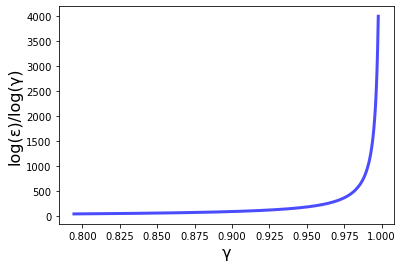

In [6]:
#hide_input
_, ax = plt.subplots(1, 1)
x = np.logspace(-0.1, -0.001, 1000)
y = np.log(1e-4) / np.log(x)
ax.set_xlabel("γ", fontsize=16)
ax.set_ylabel("log(ε)/log(γ)", fontsize=16)
_ = ax.plot(x, y, "b-", lw=3, alpha=0.7)

このように、$\gamma$が大きくなると一気に反復回数が増えることがわかります。
また、この数値計算が収束した時、真の$V^\pi$との差が
$$
\begin{aligned}
V^\pi(s) - V_k^\pi(s) &= \mathbb{E}_{s, \pi} \left[ \gamma^k R_{k + 1} + \gamma^{k + 1} R_{k + 2} ... \right] \\
&< \frac{\gamma^k R_\textrm{max}}{1 - \gamma} < \frac{\gamma \epsilon}{1 - \gamma}
\end{aligned}
$$
で抑えられることもわかります。

次は、いきなり$V^*$を求めてみましょう。
$V^\pi$を求めた時と同じように、状態$s$にいて、
あと$n$回行動できる時の最適価値関数を$V_n^*(s)$と書きます。
先ほどと同様に、$V_i^*$から1ステップ先読みして$V^*_{i + 1}$を求めます。
残り$i + 1$ステップある時、
$r(s, a) + \sum_{s' \in \mathcal{S}} P(s'|s, a) V_i^*(s)$
が最大になるような行動$a$を選ぶのが最適です。
ですから、$V^*_{i + 1}$は
$$
V_{i + 1}^*(s) = \max_a \left( r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s'|s, a) V_{i}^\pi(s') \right)
$$
で求められます。
さっきより簡単な式になってしまいました。
プログラムで書いてみます。

In [7]:
MAX_ITER_VI: int = int(1e6)


def value_iteration(
    r: Array2,
    p: Array3,
    gamma: float,
    epsilon: float,
) -> Tuple[Array1, int]:
    v = np.zeros(p.shape[0])
    for n_iter in range(MAX_ITER_VI):
        # これ↓はQ Valueとも言います
        r_plus_gamma_pv = r + gamma * np.einsum("saS,S->sa", p, v)
        v_next = r_plus_gamma_pv.max(axis=1)
        if np.all(np.absolute(v_next - v) < epsilon):
            return v_next, n_iter + 1
        v = v_next
    raise RuntimeError("Value Iteration did not converge >_<")


v_star_mdp3_vi, n_iter = value_iteration(mdp3.r, mdp3.p, 0.9, 1e-4)
print(f"反復回数: {n_iter}")
print(" ".join([f"V({i}): {v:.3}" for i, v in enumerate(v_star_mdp3_vi)]))

反復回数: 86
V(0): 6.49 V(1): 7.21 V(2): 7.51


先程と同じく、86回の反復で$V^*$が求まりました。
この反復回数も、先ほどの$V^\pi$と同じように$\gamma,\epsilon$を用いて抑えられます。

しかし、$\epsilon$は人手で設定するパラメタです。
最適方策が求まれば$V^*$は大して正確でなくとも困らないという場合は、もっと$\epsilon$を大きくして、
計算を早く終わらせたい気がします。
では、「どんな場合に$\epsilon$を大きくできるか」を考えてみましょう。

簡単のため、
$Q^\pi(s, a) = r(s, a) + \gamma \sum_{s' in \mathcal{S}} P(s'|s, a) V^\pi(s')$
(Qは[QualityのQらしい](https://twitter.com/kpb_in_acad/status/1302056205758627848))を導入します。
残り$k$ステップある時の最適行動を$a_k^* = \textrm{argmax}_a Q_k^*(s, a)$とします。
すると、$k+1$ステップ目以降の割引報酬和は
$\frac{\gamma^{k}R_\textrm{max}}{1 -\gamma}$で抑えられるので、
$$
Q_k^*(s, a_k^*) - \max_{a \neq a_k^*} Q_k^*(s, a) < \frac{\gamma^k R_\textrm{max}}{1 -\gamma}
$$
が成り立つなら、$a_k^*$が今後他の行動に逆転されることはありません。
なので$a_k^*$が最適でいいよね、はいこの話終わり、ということになります。
以下略記して
$A_\textrm{min}^*(s, a_k) = Q_k^*(s, a_k^*) - \max_{a \neq a_k^*} Q_k^*(s, a)$
と書きます（他の行動に対するアドバンテージの最小値という意味）。
いま$\gamma^{k-1} R_\textrm{max}<\epsilon$が終了条件なので、
$$
A_\textrm{min}^*(s, a_k) < \frac{\epsilon\gamma}{1 -\gamma}
\Leftrightarrow 
\frac{A_\textrm{min}^*(s, a_k)(1 - \gamma)}{\gamma}< \epsilon
$$
が成り立ちます。
これが意味するのは、**$V*$と二番目にいい$Q^*(s, a)$との差が大きいほど$\epsilon$を大きくできる**ということです。

ここまでの議論から、計算量の観点では、
- **$\gamma$が大きいほどMDPを解くのが難しい**
- **最適解と二番目にいい解との差が小さいほどMDPを解くのが難しい**

という2点が言えそうですね。

## 2.2: 方策最適化の難しさ
前節で用いた再帰的な数値計算は**動的計画法**(DP)と呼ばれるものです。
Q学習など、多くの強化学習アルゴリズムがDPをもとにしています。
一方で、単に強化学習をブラックボックス最適化だと考えることもできます。
特に、方策パラメタ$\theta$を最適化して解く方法を**方策最適化**と呼びます。

いま、$\pi(0|s) = \theta(s), \pi(1|s) = 1.0 - \theta(s)$によって$\pi$をパラメタ$\theta$により表すことにします
（これをdirect parameterizationと呼びます）。
ためしに、先ほどのMDP3で$\pi(0|0)=1.0$を固定して、$\theta(1), \theta(2)$を動かした時の$\sum_{s \in \mathcal{S}} V^\pi(s)$の変動をプロットしてみましょう。

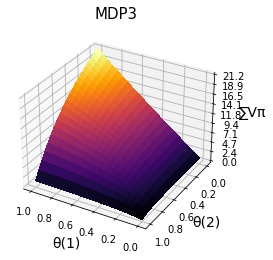

In [8]:
def v_pi_sum_2dim(
    r: Array2,
    p: Array3,
    gamma: float,
    epsilon: float,
    initial_pi: Array2,
    states: Tuple[int, int],
    n_discretization: int,
) -> Array2:
    res = []
    for i2 in range(n_discretization + 1):
        p2 = (1.0 / n_discretization) * i2
        for i1 in range(n_discretization + 1):
            p1 = (1.0 / n_discretization) * i1
            pi = initial_pi.copy()
            pi[states[0]] = p1, 1 - p1
            pi[states[1]] = p2, 1 - p2
            res.append(v_pi(r, p, pi, gamma, epsilon)[0].sum())
    return np.array(res).reshape(n_discretization + 1, -1)


def plot_piv_heatmap(
    data: Array2,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    ax: Optional[Axes] = None,
) -> Axes:
    from matplotlib.ticker import LinearLocator

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    n_discr = data.shape[0]
    x, y = np.meshgrid(np.linspace(0, 1, n_discr), np.linspace(0, 1, n_discr))
    ax.plot_surface(x, y, data, cmap="inferno", linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.01f}')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_zlabel("∑Vπ", fontsize=14, horizontalalignment="right")
    ax.set_title(title, fontsize=15)
    return ax


initial_pi = np.array([[1.0, 0.0], [0.5, 0.5], [0.5, 0.5]])
v_pi_sums = v_pi_sum_2dim(mdp3.r, mdp3.p, 0.9, 1e-4, initial_pi, (1, 2), 20)
ax = plot_piv_heatmap(v_pi_sums, "θ(1)", "θ(2)", "MDP3")
_ = ax.set_xlim(tuple(reversed(ax.get_xlim())))
_ = ax.set_ylim(tuple(reversed(ax.get_ylim())))

なんかいい感じに山になっていますね。
この問題の場合は、山登り法（勾配上昇法）で$\theta$を更新していけば大域解
$\theta(1) = 0.0, \theta(2) = 1.0$にたどり着きそうです[^5]。

しかし、$f(\theta) = \sum_{s\in\mathcal{S}} V^{\pi_\theta}(s)$は、いつもこのような性質
のいい関数になっているのでしょうが？
結論から言うと**そうではないです**。
例えば、以下のようなMDPではどうでしょうか？($\gamma=0.95$にしています)

[^5]: この記事では勾配の導出については一切触れないので、別途資料などを参照してください。

f(θ(1) = 0.0, θ(2) = 0.0): 74.25901721830479
f(θ(1) = 0.5, θ(2) = 0.5): 72.01388270994806
f(θ(1) = 1.0, θ(2) = 1.0): 70.6327625115528


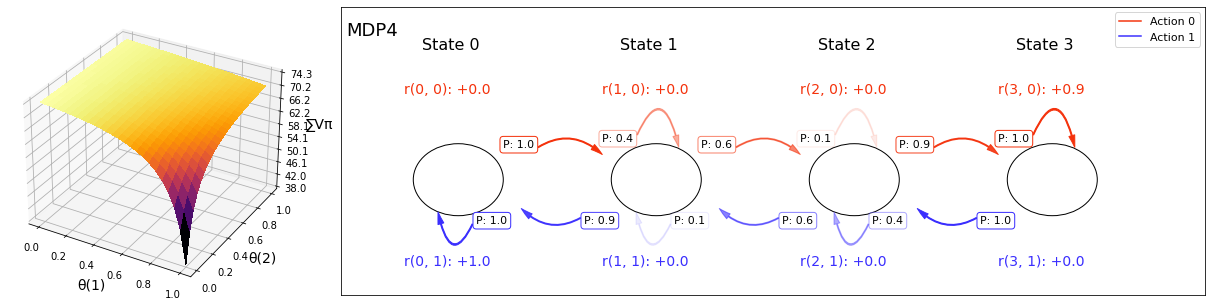

In [9]:
mdp4 = ChainMDP(
    [[1.0, 0.0], [0.6, 0.9], [0.9, 0.6], [1.0, 1.0]],
    [[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.9, 0.0]],
)
width, height = mdp4.figure_shape()
fig = plt.figure("MDP4-pi-vis", (width * 1.25, height))
mdp_ax = fig.add_axes([0.42, 0.0, 1.0, 1.0])
_ = mdp4.show("MDP4", ax=mdp_ax)
pi_ax = fig.add_axes([0.0, 0.0, 0.4, 1.0], projection="3d")
initial_pi = np.array([[0.0, 1.0], [0.5, 0.5], [0.5, 0.5], [1.0, 0.0]])
v_pi_sums = v_pi_sum_2dim(mdp4.r, mdp4.p, 0.95, 1e-4, initial_pi, (1, 2), 24)
_ = plot_piv_heatmap(v_pi_sums, "θ(1)", "θ(2)", ax=pi_ax)
print(
    f"f(θ(1) = 0.0, θ(2) = 0.0): {v_pi_sums[0][0]}\n"
    f"f(θ(1) = 0.5, θ(2) = 0.5): {v_pi_sums[12][12]}\n"
    f"f(θ(1) = 1.0, θ(2) = 1.0): {v_pi_sums[24][24]}"
)

一番右だと永遠に0.9がもらえて、一番左だと1.0がもらえるので、より**最適方策を見分けるのが難しそう**な感じがします。

プロットしてみると、$f(\theta)$は先程とは逆に谷のような形になっていて、山登り法で解いても
必ずしも大域解に収束しなそうに見えます。
これをもっと専門的な言葉で言うと、$f(0.0) + f(1.0) > 2 * f(0.5)$よりこれは**凹関数ではありません**。
あまり詳しく説明しませんが、凹関数だと山登り法が大域解に収束するなど嬉しい点があるので、
これは最適化する上で厄介な特徴だと言えます。

以上より、方策最適化で問題を解く時は**$\sum_{s\in\mathcal{S}} V(s)$が凹関数かどうか**が、
問題の難しさに影響を与えそうだということがわかりました。

## 2.A 方策反復法の難しさ

> Note: この節は特に**内容がない**のでアペンディクス扱いになっています。飛ばしても問題ありません。



ところで2.1で$V^*$を求めたときに使った手法を**価値反復法**と言います。
もう一つ、**方策反復法**という手法で$V^*$を求めることができます。

$\pi^*$が満たすべき性質について考えてみます。
$\pi$が最適であるとき、
$$
V^\pi(s) \geq \max_{a \in \mathcal{A}} r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s'|s,a) V^\pi(s')
$$
が成り立ちます。
これが成り立たないとすると、
$$
\pi'(s, a) = \begin{cases}
1.0 &(\textrm{if}~a = \textrm{argmax}_a r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s'|s,a) V^\pi(s')) \\
0.0 &(\textrm{otherwise}) 
\end{cases}
$$
の方が性能が良くなり、$\pi$が最適であることと矛盾します。

では、この性質が成り立つまで方策を改善し続けるというアルゴリズムを試してみましょう。
さっき書いた`v_pi`関数を使って実装できます。

In [10]:
MAX_ITER_PI: int = 10000

def policy_iteration(
    r: Array2,
    p: Array3,
    gamma: float,
    epsilon: float,
) -> Tuple[Array1, Array2, int]:
    pi = np.zeros(p.shape[:2])  # |S| x |A|
    pi[:, 1] = 1.0  # 最初の方策は決定的ならなんでもいいが、行動1を選ぶ方策にしてみる
    state_indices = np.arange(0, p.shape[0], dtype=np.uint)
    for n_iter in range(MAX_ITER_PI):
        v_pi_, _ = v_pi(r, p, pi, gamma, epsilon)
        q_pi = r + gamma * np.einsum("saS,S->sa", p, v_pi_)
        greedy_actions = np.argmax(q_pi, axis=1)
        pi_next = np.zeros_like(pi)
        pi_next[state_indices, greedy_actions] = 1.0
        # pi == pi_next なら収束
        if np.linalg.norm(pi - pi_next) < 1.0:
            return v_pi_, pi_next, n_iter + 1
        pi = pi_next
    raise RuntimeError("Policy Iteration did not converge >_<")

v_star_mdp3_vi, _, n_iter = policy_iteration(mdp3.r, mdp3.p, 0.9, 1e-4)
print(f"反復回数: {n_iter}")
print(" ".join([f"V({i}): {v:.3}" for i, v in enumerate(v_star_mdp3_vi)]))

反復回数: 2
V(0): 6.49 V(1): 7.21 V(2): 7.51


なんか2回反復しただけで求まってしまいましたが...。
このアルゴリズムは**方策反復法**と呼ばれ、なんやかんやで最適方策に収束することが知られています。
では、この反復回数は、何によって決まるのでしょうか？
方策の組み合わせは$|A|^{|S|}$通りありますが、上の実験だとずっと速く収束しているので、もっといいバウンドがありそうに思えます。
しかし、実際のところ最悪ケースでは指数時間かかることが知られています。
この記事では、この方策反復法が難しくなる場合についても解説したかったのですが、
**理解できなかったので、諦めました**。ヾ(｡>﹏<｡)ﾉ

## 2.B 参考文献など

- [On the Complexity of Solving Markov Decision Problems](https://arxiv.org/abs/1302.4971)
- [Cournell CS 6789: Foundations of Reinforcement Learning](https://wensun.github.io/CS6789_data/comp_limits.pdf)

参考文献では$\frac{1}{1 - \gamma}$で反復回数を抑えているじゃないか、話が違うじゃないか、という気が一見してしまいます。
これは[有名不等式](https://mathtrain.jp/kldiv)$\log x \leq x - 1$
からなんやかんやで$\frac{1}{1 - \gamma} \geq -\frac{1}{\log\gamma}$
だから〜という感じで考えればなんとかなると思います。
この不等式は$x=1$で等号なので、よく使う$\gamma=0.99$とかの設定ならかなり差は近くなります。

# 3. オンライン学習としての側面: データを収集することの難しさ
前節では、環境の情報から$V^*$や$\pi^*$を計算してみました。
この節では、満を持して学習の問題に取り組んでいこうと思います。

学習する理由として、
1. $P$や$r$がわからない わからないが、なぜかシミュレーションすることはできる
2. $P$も$r$もわかっているが、問題が大きすぎて $O(|S|^2 |A| \frac{...}{1 - \gamma})$ とか解けなさそう

...などがあると思いますが、ここでは**最もゆるい設定**を考えます。
MDPのパラメタはわからないが、あるMDPを使って行動できるシミュレータがあります。
これを**環境**と呼ぶことにしましょう。

環境の中で行動$a_t$をとると、
次の状態$s_{t+1}$が$P(s_{t+1}|s_t,a_t)$からサンプリングされて与えられます。
同時に報酬$r(s_t, a_t)$も与えられます。
この環境の中で、適当に行動しているとなんやかんやで情報が集まってきて問題が解ける
というのが強化学習の仕組みです。
しかし、本当に適当に行動してしまっていいのでしょうか。

## 3.1 報酬なし探査の問題
というわけで、とりあえず別に学習しなくていいので、環境から情報を集めてこよう、という問題を考えてみましょう。

In [11]:
from matplotlib.figure import Figure
from matplotlib.image import FigureImage


class GridMDP:
    from matplotlib.colors import ListedColormap

    #: Up, Down, Left, Right
    ACTIONS = np.array([[-1, 0], [+1, 0], [0, -1], [0, +1]])
    #: Symbols
    EMPTY, BLOCK, START, GOAL = range(4)
    DESCRIPTIONS = ["Empty", "Block", "Start", "Goal"]
    #: Colormap for visualizing the map
    CM = ListedColormap(["w", ".75", "xkcd:leaf green", "xkcd:vermillion"])
    REWARD_COLORS = ["xkcd:light royal blue", "xkcd:vermillion"]
    FIG_AREA = 28

    # Returns PIL.Image
    def __download_agent_image():
        from io import BytesIO
        from urllib import request

        from PIL import Image

        fd = BytesIO(
            request.urlopen(
                "https://2.bp.blogspot.com/-ZwYKR5Zu28s/U6Qo2qAjsqI"
                + "/AAAAAAAAhkM/HkbDZEJwvPs/s400/omocha_robot.png"
            ).read()
        )
        return Image.open(fd)

    AGENT_IMAGE = __download_agent_image()

    def __init__(
        self,
        map_array: Sequence[Sequence[int]],
        reward_array: Optional[Sequence[Sequence[float]]] = None,
        action_noise: float = 0.1,
        horizon: Optional[int] = None,
        seed: int = 123456789,
        legend_loc: str = "upper right",
    ) -> None:
        def add_padding(seq: Sequence[Sequence[T]], value: T) -> list:
            width = len(seq[0]) + 2
            ret_list = [[value for _ in range(width)]]
            for col in seq:
                ret_list.append([value] + list(col) + [value])
            ret_list.append([value for _ in range(width)])
            return ret_list

        self.map_array = np.array(add_padding(map_array, 1), dtype=np.uint8)
        assert self.map_array.max() <= 3
        assert 0 <= self.map_array.min()
        self.rows, self.cols = self.map_array.shape

        if reward_array is None:
            self.reward_array = np.zeros((self.rows, self.cols), np.float64)
        else:
            self.reward_array = np.array(
                add_padding(reward_array, 0.0), np.float64
            )

        self.action_noise = action_noise
        self.horizon = horizon
        self.start_positions = np.argwhere(self.map_array == self.START)
        if len(self.start_positions) == 0:
            raise ValueError("map_array needs at least one start posiiton")
        self.random_state = np.random.RandomState(seed)
        _ = self.reset()

        # Visualization stuffs
        self.legend_loc = legend_loc
        self.map_fig, self.map_ax, self.map_img = None, None, None
        self.agent_img, self.agent_fig_img = None, None

    def n_states(self) -> int:
        return np.prod(self.map_array.shape)

    @staticmethod
    def n_actions() -> int:
        return 4

    def reset(self) -> Array1:
        idx = self.random_state.randint(self.start_positions.shape[0])
        self.state = self.start_positions[idx]
        self.n_steps = 0
        return self.state.copy()

    def state_index(self, state: Array1) -> int:
        y, x = state
        return y * self.map_array.shape[1] + x

    def _load_agent_img(self, fig_height: float) -> None:
        from io import BytesIO
        from urllib import request

        fd = BytesIO(request.urlopen(self.ROBOT).read())
        img = Image.open(fd)
        scale = fig_height / img.height
        self.agent_img = img.resize((int(img.width * scale), int(img.height * scale)))

    def _fig_inches(self) -> Tuple[int, int]:
        prod = self.rows * self.cols
        scale = np.sqrt(self.FIG_AREA / prod)
        return self.cols * scale, self.rows * scale

    def _is_valid_state(self, *args) -> bool:
        if len(args) == 2:
            y, x = args
        else:
            y, x = args[0]
        return 0 <= y < self.rows and 0 <= x < self.cols

    def _possible_actions(self) -> Array1:
        possible_actions = []
        for i, act in enumerate(self.ACTIONS):
            y, x = self.state + act
            if self._is_valid_state(y, x) and self.map_array[y, x] != self.BLOCK:
                possible_actions.append(i)
        return np.array(possible_actions)

    def _reward(self, next_state: Array1) -> float:
        y, x = next_state
        return self.reward_array[y, x]

    def _is_terminal(self) -> bool:
        if self.horizon is not None and self.n_steps > self.horizon:
            return True
        y, x = self.state
        return self.map_array[y, x] == self.GOAL

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        self.n_steps += 1
        possible_actions = self._possible_actions()
        if self.random_state.random_sample() < self.action_noise:
            action = self.random_state.choice(possible_actions)

        if action in possible_actions:
            next_state = self.state + self.ACTIONS[action]
        else:
            next_state = self.state.copy()

        reward = self._reward(next_state)
        self.state = next_state
        is_terminal = self._is_terminal()
        return next_state.copy(), reward, is_terminal

    def _draw_agent(self, fig: Figure) -> FigureImage:
        unit = self.map_img.get_window_extent().y1 / self.rows
        y, x = self.state
        return fig.figimage(
            self.agent_img,
            unit * (x + 0.3),
            unit * (self.rows - 0.8 - y),
        )

    def _draw_rewards(self) -> None:
        for y in range(self.rows):
            for x in range(self.cols):
                rew = self.reward_array[y, x]
                if abs(rew) < 1e-3:
                    continue
                if self.map_array[y, x] == self.GOAL:
                    color = "w"
                else:
                    color = self.REWARD_COLORS[int(rew >= 0)]
                self.map_ax.text(
                    x + 0.1,
                    y + 0.5,
                    f"{rew:+.2}",
                    color=color,
                    fontsize=12,
                )

    def show(self, title: str = "", explicit: bool = False) -> Axes:
        if self.map_fig is None:
            self.map_fig = plt.figure(title or "GridMDP", self._fig_inches())
            ax = self.map_fig.add_axes([0, 0, 1, 1])
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])
            self.map_img = ax.imshow(
                self.map_array,
                cmap=self.CM,
                extent=(0, self.cols, self.rows, 0),
                vmin=0,
                vmax=4,
                alpha=0.6,
            )
            for i in range(1, 4):
                if np.any(self.map_array == i):
                    ax.plot([0.0], [0.0], color=self.CM(i), label=self.DESCRIPTIONS[i])
            ax.legend(fontsize=12, loc=self.legend_loc)
            ax.text(0.1, 0.8, title or "GridMDP", fontsize=16)
            self.map_ax = ax

            imw, imh = self.AGENT_IMAGE.width, self.AGENT_IMAGE.height
            scale = (self.map_img.get_window_extent().y1 / self.rows) / imh
            self.agent_img = self.AGENT_IMAGE.resize(
                (int(imw * scale), int(imh * scale))
            )

            if np.linalg.norm(self.reward_array) > 1e-3:
                self._draw_rewards()
        if self.agent_fig_img is not None:
            self.agent_fig_img.remove()
        self.agent_fig_img = self._draw_agent(self.map_fig)
        if explicit:
            from IPython.display import display

            self.map_fig.canvas.draw()
            display(self.map_fig)
        return self.map_ax

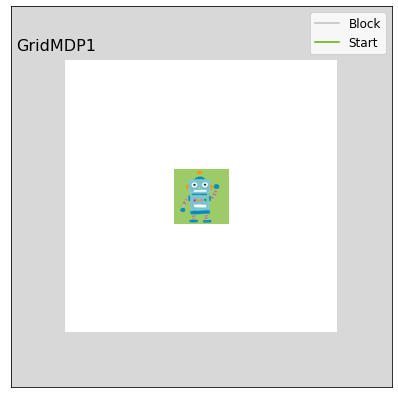

In [12]:
grid_mdp1 = GridMDP(
    [[0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0], 
     [0, 0, 2, 0, 0],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0]],
    horizon=50,
)
_ = grid_mdp1.show("GridMDP1")

GridMDPと題されたこちらが、今回使用する「環境」になります。
環境の中で行動する主体をエージェントと呼びます。
今回は、[いらすとや](https://www.irasutoya.com/)様のロボットの画像を使用させていただきました。
各マス目の中で、エージェントは行動は上下左右に移動の4種類の行動を選択できます。
行動は時々失敗して、一様ランダムな状態遷移が発生します。
ここで、前章で用いなかったいくつかの新しい概念を導入します。

- 「スタート地点」の存在
  - ロボットくんは、決められた場所から行動を始めなくてはなりません。この問題では、初期状態はあらかじめ決まられたいくつかのスタート地点から均等に選びます。理論的なフレームワークでは、初期状態分布$\mu: \mathcal{S} \rightarrow \mathbb{R}$として表現すればいいです。
- 「終了地点」の存在
  - ロボットくんは、いくつかの決められた場所に到達したら強制的にスタートまで戻されます。
- エピソード
  - スタートから終了するまでの一連の流れをエピソードと呼びます。
- 「エピソード長さ（ホライゾン）」の存在
  - 一定のターンが経過した時、ロボットくんはスタート地点まで戻されます。強化学習ではしばしば、シミュレーターを何度もリセットして学習します。理論を実際に近づけるため、MDPのフレームワークにもこれが導入される場合があります。

ではさっそく、適当に行動してもらいましょう。
エージェントをランダムに行動させて、訪問した場所に色をつけていきます。
なお、エピソード長さは50とします。

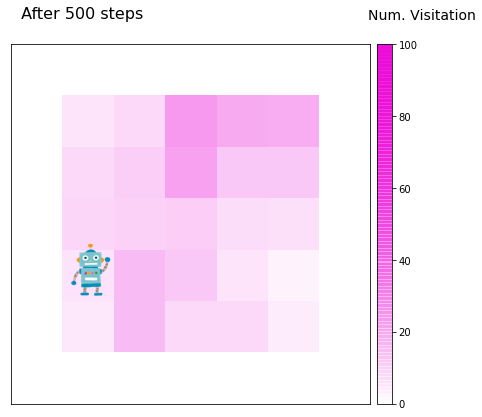

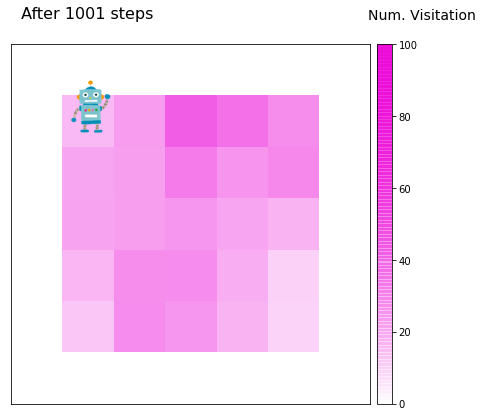

In [13]:
from abc import ABC, abstractmethod
from typing import Callable


class VisitationHeatmap:
    def __init__(
        self,
        map_shape: Tuple[int, int],
        figsize: Tuple[float, float],
        ax: Optional[Axes] = None,
        max_visit: int = 1000,
        title: str = "",
    ) -> None:
        from matplotlib import colors as mc
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        self.counter = np.zeros(map_shape, np.int64)
        self.title = title
        self.fig = plt.figure(self.title, figsize, facecolor="w")
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        self.ax.set_aspect("equal")
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        r, g, b = mc.to_rgb("xkcd:fuchsia")
        cdict = {
            "red": [(0.0, r, r), (1.0, r, r)],
            "green": [(0.0, g, g), (1.0, g, g)],
            "blue": [(0.0, b, b), (1.0, b, b)],
            "alpha": [(0.0, 0.0, 0.0), (1.0, 1.0, 1.0)],
        }
        self.img = self.ax.imshow(
            np.zeros(map_shape),
            cmap=mc.LinearSegmentedColormap("visitation", cdict),
            extent=(0, map_shape[1], map_shape[0], 0),
            vmin=0,
            vmax=max_visit,
        )

        divider = make_axes_locatable(self.ax)
        cax = divider.append_axes("right", size="4%", pad=0.1)
        self.fig.colorbar(self.img, cax=cax, orientation="vertical")
        cax.set_ylabel("Num. Visitation", rotation=0, position=(1.0, 1.1), fontsize=14)

        self._update_text()
        self.agent = None

    def _update_text(self) -> None:
        self.text = self.ax.text(
            0.1,
            -0.5,
            f"{self.title} After {self.counter.sum()} steps",
            fontsize=16,
        )

    def _draw_agent(self, draw: Callable[[Figure], FigureImage]) -> None:
        if self.agent is not None:
            self.agent.remove()
        self.agent = draw(self.fig)

    def visit(self, state: Array1) -> int:
        y, x = state
        res = self.counter[y, x]
        self.counter[y, x] += 1
        self.img.set_data(self.counter)
        self.text.remove()
        self._update_text()
        return res

    def show(self) -> None:
        from IPython.display import display

        display(self.fig)


def do_nothing(
    _state: int,
    _action: int,
    _next_state: int,
    _reward: float,
    _is_terminal: bool,
) -> None:
    return


def simulation(
    mdp: GridMDP,
    n: int,
    act: Callable[[int], int],
    learn: Callable[[int, int, int, float, bool], None] = do_nothing,
    max_visit: Optional[int] = None,
    vis_freq: Optional[int] = None,
    vis_last: bool = False,
    title: str = "",
) -> None:
    visitation = VisitationHeatmap(
        mdp.map_array.shape,
        mdp._fig_inches(),
        max_visit=max_visit or n // 10,
        title=title,
    )
    state = mdp.reset()
    visitation.visit(state)
    vis_interval = n + 1 if vis_freq is None else n // vis_freq
    for i in range(n):
        if (i + 1) % vis_interval == 0 and (vis_last or i < n - 1):
            visitation._draw_agent(mdp._draw_agent)
            visitation.show()
        action = act(mdp.state_index(state))
        next_state, reward, terminal = mdp.step(action)
        visitation.visit(next_state)
        learn(
            mdp.state_index(state),
            action,
            mdp.state_index(next_state),
            reward,
            terminal,
        )
        if terminal:
            state = mdp.reset()
        else:
            state = next_state
    visitation._draw_agent(mdp._draw_agent)


simulation(grid_mdp1, 1000, lambda _: np.random.randint(4), vis_freq=2)

ランダムに行動させただけですが、それなりにまんべんなく色が塗られていて、まあまあいいのではないか、という気がします。
しかし、もっと広い環境ではどうでしょうか。

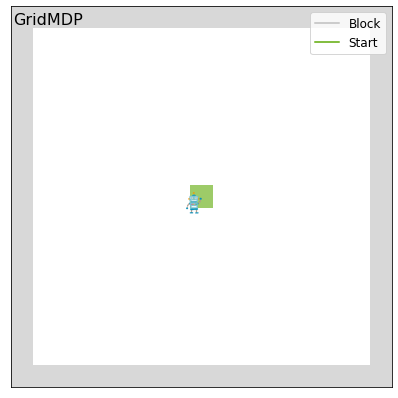

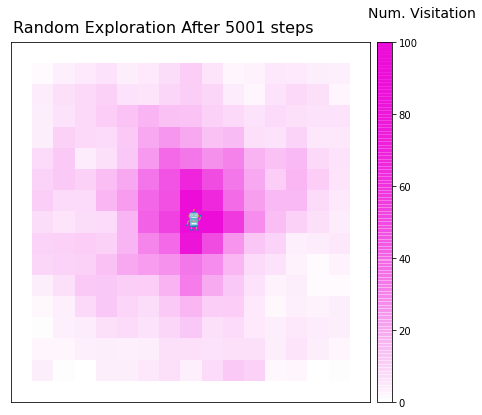

In [14]:
grid_mdp2_map = [[0] * 15 for _ in range(15)]
grid_mdp2_map[7][7] = 2
grid_mdp2 = GridMDP(grid_mdp2_map, horizon=50)
_ = grid_mdp2.show()
random_state = np.random.RandomState(1)
simulation(
    grid_mdp2,
    5000,
    lambda _: random_state.randint(4),
    max_visit=100,
    title="Random Exploration",
    vis_freq=None,
)

なんか駄目っぽい感じですね。
場所によっては全く色がついていません。
環境が広いと、ランダムに歩き回るのでは、効率よく情報を集めてこれないようです。
具体的にどのくらい難しいのかと言うと、平均一回訪問するのにかかる時間が、だいたい
- 一方通行の直線: $O(|S|)$
- 二次元ランダムウォーク: $O(|S|^2)$? (参考: [plane上のランダムウォーク](https://mathworld.wolfram.com/RandomWalk2-Dimensional.html)）
- 最悪ケース: $O(2^{|S|})$

くらいになります。
一方通行なのはなんとなくわかりますね。
ランダムウォークの場合、同じ場所を行ったりきたりできるので、そのぶん時間がかかってしまいます。
最悪ケースは、以下のように構成すればいいです。

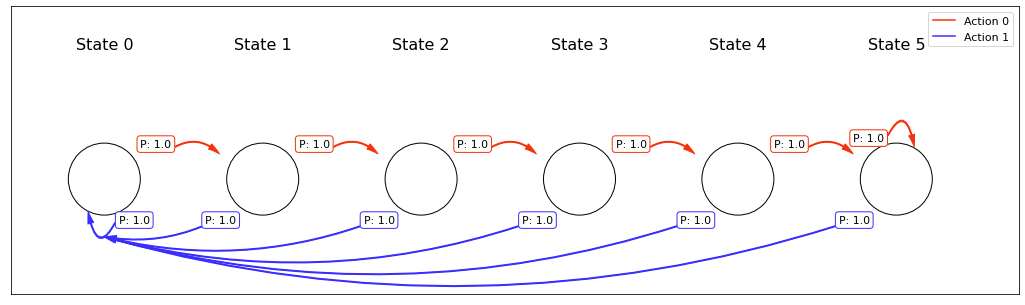

In [15]:
# hide-input
class WorstCaseMDP(ChainMDP):
    def __init__(self, n: int) -> None:
        self.n_states = n
        # For plotting
        self.circles = []
        self.cached_ax = None

    def show(self, title: str = "", ax: Optional[Axes] = None) -> Axes:
        # だいたいChainMDPからコピペ...
        if self.cached_ax is not None:
            return self.cached_ax

        from matplotlib.patches import Circle

        width, height = self.figure_shape()
        circle_position = height / 2 - height / 10
        if ax is None:
            fig = plt.figure(title or "ChainMDP", (width, height))
            ax = fig.add_axes([0, 0, 1, 1], aspect=1.0)
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_xticks([])
        ax.set_yticks([])

        def xi(si: int) -> float:
            return self.OFFSET + (1.0 + self.INTERVAL) * si + 0.5

        self.circles = [
            Circle((xi(i), circle_position), 0.5, fc="w", ec="k")
            for i in range(self.n_states)
        ]
        for i in range(self.n_states):
            x = self.OFFSET + (1.0 + self.INTERVAL) * i + 0.1
            ax.text(x, height * 0.85, f"State {i}", fontsize=16)

        def annon(act: int, *args, **kwargs) -> None:
            # We don't hold references to annotations (i.e., we treat them immutable)
            a_to_b(
                ax,
                *args,
                **kwargs,
                arrowcolor=self.ACT_COLORS[act],
                text=f"P: 1.0",
                fontsize=11,
            )

        for si in range(self.n_states):
            ax.add_patch(self.circles[si])
            x = xi(si)
            # Action 0:
            y = circle_position + self.SHIFT
            if si < self.n_states - 1:
                annon(
                    0,
                    (x + self.SHIFT, y),
                    (xi(si + 1) - self.SHIFT * 1.2, y - self.SHIFT * 0.3),
                    verticalalignment="center_baseline",
                )
            else:
                annon(
                    0,
                    (x - self.SHIFT * 1.2, y),
                    (x + self.SHIFT * 0.5, y - self.SHIFT * 0.1),
                    style="self",
                    verticalalignment="bottom",
                )
            # Action 1:
            y = circle_position - self.SHIFT
            if si > 0:
                annon(
                    1,
                    (x - self.SHIFT * 1.6, y),
                    (xi(0), y - self.SHIFT * 0.6),
                    style="arc3,rad=-0.15",
                    verticalalignment="top",
                )
            else:
                annon(
                    1,
                    (x + self.SHIFT * 0.4, y),
                    (x - self.SHIFT * 0.45, y + self.SHIFT * 0.1),
                    style="self",
                    verticalalignment="top",
                )

        for i in range(2):
            ax.plot([0.0], [0.0], color=self.ACT_COLORS[i], label=f"Action {i}")
        ax.legend(fontsize=11, loc="upper right")
        if len(title) > 0:
            ax.text(0.06, height * 0.9, title, fontsize=18)
        self.cached_ax = ax
        return ax


_ = WorstCaseMDP(6).show()

この環境で状態$0$からランダムに行動すると、右端にたどり着くまでに平均$2^5$くらいのステップ数がかかります。
そんなんありかよ...って感じですが。

この結果から、最悪の場合だと指数時間かかるから賢くデータ収集しないといけないよね、
思うこともできます。
その一方で、ランダムウォークのように遷移の対称性がある環境なら、
ランダムに行動してもそんなに悪くないんじゃないかな、とも思えます。

さてその話は一旦おいておいて、もっと効率よくデータを集める方法を考えてみましょう。

1. 訪問した場所を覚えておいて、訪問していない場所を優先して探査する
2. 状態と状態の間に距離が定義できると仮定して、遠くに行くようにする
3. 環境がユークリッド空間だと仮定してSLAMで自己位置推定する

など、色々な方法が考えられると思いますが、ここでは1の方法を使ってみましょう。

以下のようなアルゴリズムを考えます。
1. 適当な方策$\pi_0$から開始する
2. 状態行動訪問回数$n(s, a)$、状態行動次状態訪問回数$n(s, a, s')$を記録しておく
  - ただし、初期値は$n_0(s, a) = 1.0, n_0(s, a, s) = \frac{1}{|S|}$とする(0除算防止のため)
3. エピソードが終わったとき、以下のように方策を更新する
  1. 状態遷移関数の推定値$\hat{P}(s'|s, a) = \frac{n(s, a, s')}{n(s, a}$、**疑似報酬**$r_k(s, a)=\frac{1}{n(s, a)}$、適当な$\gamma$から成るMDP$\mathcal{M}_k$を解く
  2. $\mathcal{M}_k$の最適価値関数$V^*_k,Q^*_k$から以下のように方策$pi_{k+1}$を構成する
    - $V^*_k(s) < \frac{1}{|S|}\sum_{s'\in\mathcal{S}}V^*_k(s')$ なら $\pi_{k+1}(s)$は$Q^*_k$に基づく貪欲行動
    - それ以外の場合、$\pi_{k+1}(s)$は一様ランダムな行動をとる (=方策を**緩和**する)
    
疑似報酬$r_k=\frac{1}{n(s, a)}$を使用してプランニングするのが、最も重要なポイントです。
この値は、一度も状態行動ペア$(s,a)$を経験していないなら$1$、一度経験したら$1/2$、2回経験したら$1/3$のように減衰します。
これを報酬とするMDPを解くことで、あまり経験していない状態行動ペアをとろうとする方策が得られます。
完全な貪欲方策ではなく緩和をいれているのは、高い報酬の状態をループしないようにするためです。
では、やってみましょう。

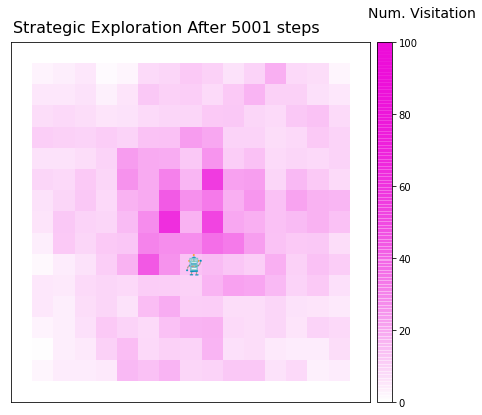

In [16]:
class RewardFreeExplore:
    def __init__(
        self,
        n_states: int,
        n_actions: int,
        seed: int = 1,
        gamma: float = 0.95,
    ) -> None:
        self.sa_count = np.ones((n_states, n_actions))
        self.sas_count = np.ones((n_states, n_actions, n_states)) / n_states
        self.pi = np.ones((n_states, n_actions)) / n_actions
        self.random_state = np.random.RandomState(seed)
        self.n_states, self.n_actions = n_states, n_actions
        self.n_updates = 0
        self.gamma = gamma
        self.pi_indices = np.arange(n_states, dtype=np.uint32)

    def learn(
        self,
        state: int,
        action: int,
        next_state: int,
        reward: float,
        is_terminal: bool,
    ) -> None:
        # 訪問記録を更新する
        self.sa_count[state, action] += 1
        if is_terminal:
            # エピソードが終わったら、Value Iterationを解いて方策を更新する
            r = 1.0 / self.sa_count
            p = self.sas_count / np.expand_dims(self.sa_count, axis=-1)
            v, _n_iter = value_iteration(r, p, self.gamma, 1e-2)
            v_is_larger_than_mean = v > v.mean()
            q = r + self.gamma * np.einsum("saS,S->sa", p, v)
            self.pi.fill(0.0)
            for state in range(self.n_states):
                # Vが大きい場所では方策を緩和する
                if v_is_larger_than_mean[state]:
                    self.pi[state] = 1.0 / self.n_actions
                # そうでない場合は貪欲
                else:
                    self.pi[state][q[state].argmax()] = 1.0
            self.n_updates += 1
        else:
            self.sas_count[state, action, next_state] += 1

    def act(self, state: int) -> int:
        return self.random_state.choice(self.n_actions, p=self.pi[state])


agent = RewardFreeExplore(grid_mdp2.n_states(), grid_mdp2.n_actions())
simulation(
    grid_mdp2,
    5000,
    agent.act,
    learn=agent.learn,
    max_visit=100,
    title="Strategic Exploration",
    vis_freq=None,
)

さっきよりも満遍なく、色々な状態を訪問してくれるようになりましたね。

## 3.2 報酬あり探査
次は、環境から報酬が与えられるので、なるべく早く学習を終わらせたい、という問題を考えます。
訪問していない場所に積極的にいけばいい、という方針はさっきと変わりません。
一方で、**あまりに報酬がもらえなさそうな状態はとっとと諦める**ことをしなくてはいけない点が異なっています。

例えば、報酬の推定値を$\hat{r}(s, a)$とするとき、先ほどのアルゴリズムの疑似報酬を
$r_k(s, a)=\hat{r}(s, a)+\frac{\beta}{\sqrt{n(s, a)}}$とすればいいです。
これを、単に$r_k(s, a)=\hat{r}(s, a)$とするアルゴリズム(Approximate Value Iteration)と比較してみましょう。
こちらは、確率$\epsilon$で一様分布から行動をサンプリングし、$1-\epsilon$で$Q^*_k$が一番大きい行動を選択するという行動方策を使ってみましょう（$\epsilon$-Greedyと言います）。
今回は$\epsilon=0.9 \rightarrow 0.4$とします。

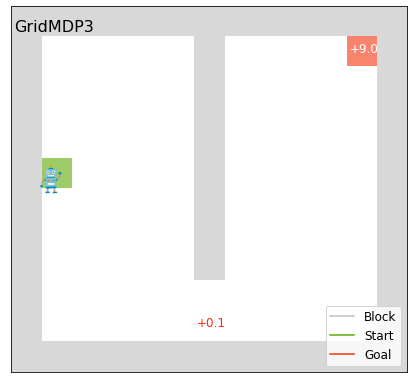

In [17]:
grid_mdp3 = GridMDP(
    [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0]],
    horizon=100,
    legend_loc="lower right"
)
_ = grid_mdp3.show("GridMDP3")

まず、こちらの環境で実験してみます。素直に$0.1$の報酬→$9.0$の報酬を目指せばいい感じです。
また、$\gamma=0.99$とします。

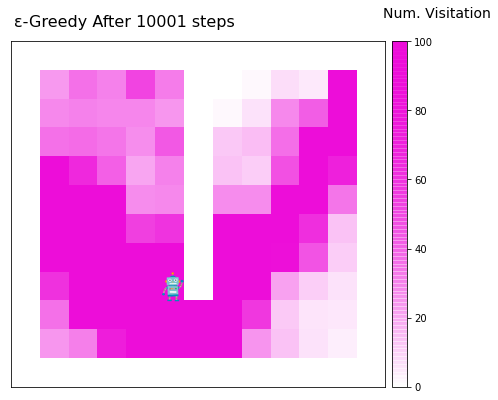

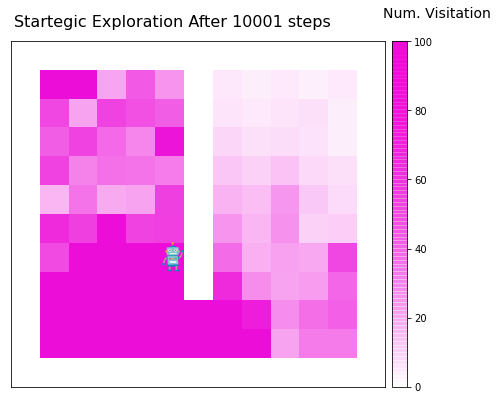

In [18]:
class EpsgApproxVI:
    def __init__(
        self,
        n_states: int,
        n_actions: int,
        seed: int = 1,
        gamma: float = 0.99,
        epsilon: float = 0.9,
        epsilon_delta: float = 0.0001,
    ) -> None:
        self.sa_count = np.ones((n_states, n_actions))
        self.sas_count = np.ones((n_states, n_actions, n_states)) / n_states
        self.r_sum = np.zeros((n_states, n_actions))
        self.pi = np.ones((n_states, n_actions)) / n_actions
        self.random_state = np.random.RandomState(seed)
        self.n_states, self.n_actions = n_states, n_actions
        self.n_updates = 0
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_delta = epsilon_delta
        self.pi_indices = np.arange(n_states, dtype=np.uint32)

    def learn(
        self,
        state: int,
        action: int,
        next_state: int,
        reward: float,
        is_terminal: bool,
    ) -> None:
        self.sa_count[state, action] += 1
        self.r_sum[state, action] += reward
        if is_terminal:
            r = self.r_sum / self.sa_count
            p = self.sas_count / np.expand_dims(self.sa_count, axis=-1)
            v, _n_iter = value_iteration(r, p, self.gamma, 1e-2)
            q = r + self.gamma * np.einsum("saS,S->sa", p, v)
            self.pi.fill(0)
            for state in range(self.n_states):
                self.pi[state][q[state].argmax()] = 1.0
            self.n_updates += 1
        else:
            self.sas_count[state, action, next_state] += 1

    def act(self, state: int) -> int:
        if self.random_state.rand() < self.epsilon:
            self.epsilon -= self.epsilon_delta
            return self.random_state.choice(self.n_actions)
        else:
            return self.random_state.choice(self.n_actions, p=self.pi[state])


class MBIB_EB:
    def __init__(
        self,
        n_states: int,
        n_actions: int,
        seed: int = 1,
        gamma: float = 0.99,
        beta: float = 0.1,
    ) -> None:
        self.sa_count = np.ones((n_states, n_actions))
        self.sas_count = np.ones((n_states, n_actions, n_states)) / n_states
        self.r_sum = np.zeros((n_states, n_actions))
        self.pi = np.ones((n_states, n_actions)) / n_actions
        self.random_state = np.random.RandomState(seed)
        self.n_states, self.n_actions = n_states, n_actions
        self.n_updates = 0
        self.gamma = gamma
        self.beta = beta
        self.pi_indices = np.arange(n_states, dtype=np.uint32)
    
    def learn(
        self,
        state: int,
        action: int,
        next_state: int,
        reward: float,
        is_terminal: bool,
    ) -> None:
        self.sa_count[state, action] += 1
        self.r_sum[state, action] += reward
        if is_terminal:
            r = self.r_sum / self.sa_count + self.beta / np.sqrt(self.sa_count)
            p = self.sas_count / np.expand_dims(self.sa_count, axis=-1)
            v, _n_iter = value_iteration(r, p, self.gamma, 1e-2)
            v_is_larger_than_mean = v > v.mean()
            q = r + self.gamma * np.einsum("saS,S->sa", p, v)
            self.pi.fill(0.0)
            for state in range(self.n_states):
                if v_is_larger_than_mean[state]:
                    self.pi[state] = 1.0 / self.n_actions
                else:
                    self.pi[state][q[state].argmax()] = 1.0
            self.n_updates += 1
        else:
            self.sas_count[state, action, next_state] += 1

    def act(self, state: int) -> int:
        return self.random_state.choice(self.n_actions, p=self.pi[state])


epsg_vi = EpsgApproxVI(grid_mdp3.n_states(), grid_mdp3.n_actions())
simulation(
    grid_mdp3,
    10000,
    epsg_vi.act,
    learn=epsg_vi.learn,
    max_visit=100,
    title="ε-Greedy",
    vis_freq=None,
)
mbib_eb = MBIB_EB(grid_mdp3.n_states(), grid_mdp3.n_actions())
simulation(
    grid_mdp3,
    10000,
    mbib_eb.act,
    learn=mbib_eb.learn,
    max_visit=100,
    title="Startegic Exploration",
    vis_freq=None,
)

両方とも、いい感じに探査してくれているように見えます。
$\epsilon$-Greedyの方が、$R_t=9.0$がもらえるゴールの周辺を多く探査していて、
良さそうに見えます。
一方で、もう少し意地悪な環境の場合はどうでしょうか？

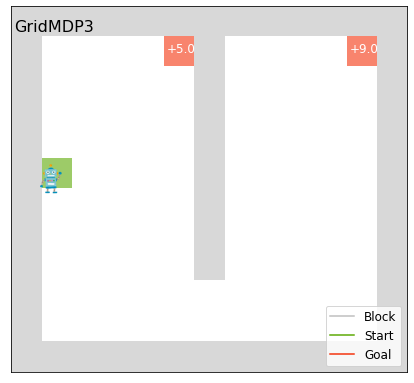

In [19]:
grid_mdp4 = GridMDP(
    [[0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
    [[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 9.0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
    horizon=100,
    legend_loc="lower right"
)
_ = grid_mdp4.show("GridMDP3")

この環境では、$+5.0$とかいう邪魔くさい報酬があります。
しかもここはゴールなので、ここに行くとまたリセットしてやり直しです。
ここを目指すように学習してしまうと、なかなか$+9.0$の方に行くのは厳しそうに見えます。
実験してみましょう。

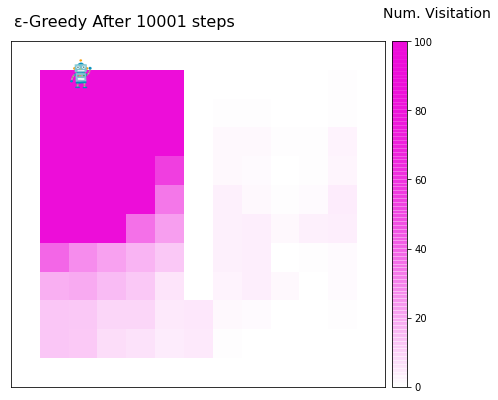

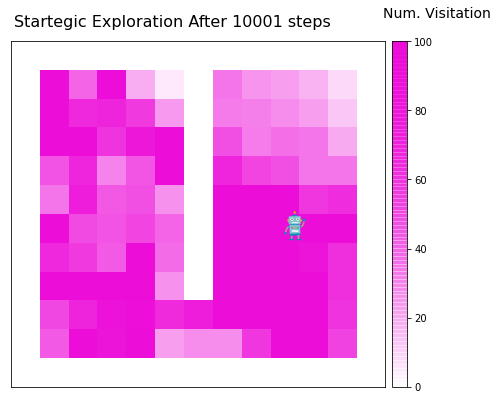

In [20]:
epsg_vi = EpsgApproxVI(grid_mdp4.n_states(), grid_mdp4.n_actions())
simulation(
    grid_mdp4,
    10000,
    epsg_vi.act,
    learn=epsg_vi.learn,
    max_visit=100,
    title="ε-Greedy",
    vis_freq=None,
)
mbib_eb = MBIB_EB(grid_mdp4.n_states(), grid_mdp4.n_actions())
simulation(
    grid_mdp4,
    10000,
    mbib_eb.act,
    learn=mbib_eb.learn,
    max_visit=100,
    title="Startegic Exploration",
    vis_freq=None,
)

予想通り、$\epsilon$-Greedyの方は右上ばかり行ってしまってイマイチな感じになりました。

以上の結果から、
- 邪魔がなく遷移関数が対称な状態空間（ランダムウォークのように考えられるもの）では、わりあい簡単にデータ収集ができる
- 邪魔な報酬がない環境では、わりあい簡単にデータ収集ができる

という2点が言えるかと思います。
ワーストケースを考えると探査が難しいのも事実ですが、実用上は難しいケースを考えるより**邪魔な報酬を排除する**
ことを考えるのが重要です。

## 3.A 参考文献など
1. [On the Sample Complexity of Reinforcement Learning](https://homes.cs.washington.edu/~sham/papers/thesis/sham_thesis.pdf)
2. [Reward-Free Exploration for Reinforcement Learning](https://arxiv.org/abs/2002.02794)
3. [Sample Complexity Bounds of Exploration](https://link.springer.com/chapter/10.1007/978-3-642-27645-3_6)
4. [An analysis of model-based Interval Estimation for Markov Decision Processes](https://www.sciencedirect.com/science/article/pii/S0022000008000767)

3.1で紹介したアルゴリズムは一応2.の文献を参考にしていますが、**僕がさっき適当に考えた**(は？)ものです。
理論保証があるかはあやしいと思います。
3.2のやつはMBIB-EB(4.)に似ていますが、方策の緩和が入っている点が違います。
緩和も僕が適当に考えたものなのですが、入れた方が性能が良かったので入れてみました。
良い子の皆さんは真似しないでください。

# 4. 結論

**強化学習で重要なのは1に報酬、2に報酬、3、4がなくて5に$\gamma$(もしくはエピソード長さ$H$)**です。

- 最適解と2番目にいい解の差が大きくなるように問題を設計しましょう
- $\gamma$はできる限り小さくしましょう

これらの点について納得いただければ、この記事は成功と言えるのではないかな、と思います。
本当はもう少し書きたいこともあるのですが...。

何か質問・誤りの指摘などあればコメント欄からお願いします。

# 5. 謝辞
強化学習苦手の会もくもく会主催の品川さんおよび、参加者の方々との有意義な議論に感謝します。